In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import sklearn
import pickle
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle
from tqdm import tqdm

In [4]:
path = 'Bone Break Classification'
class_list = os.listdir(path)
print(class_list)

['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture']


In [30]:
# Initialize empty lists to store images and corresponding labels for training and testing data.
X_train, y_train = [], []
X_test, y_test = [], []

for (index, _class) in enumerate(class_list):

    class_path = os.path.join(path, _class)

    # Loop through all the image files in the 'Train' folder.
    train_path = os.path.join(class_path, 'Train')
    for img_path in os.listdir(train_path):
        # Construct full path of image file
        full_path = os.path.join(train_path, img_path)

        # Read the image in grayscale mode
        image = cv2.imread(full_path, 0)

        # Resize the image to 256x256
        image = cv2.resize(image, (256,256))
        
        X_train.append(image)
        y_train.append(index)

    # Loop through all the image files in the 'Test' folder.
    test_path = os.path.join(class_path, 'Test')
    for img_path in os.listdir(test_path):
        # Construct full path of image file
        full_path = os.path.join(test_path, img_path)

        # Read the image in grayscale mode
        image = cv2.imread(full_path, 0)

        # Resize the image to 256x256
        image = cv2.resize(image, (256,256))

        X_test.append(image)
        y_test.append(index)

y_test = np.array(y_test)

In [7]:
with open("./models/kmeans_sift.pkl", 'rb') as f:
    kmeans_sift = pickle.load(f)

with open("./models/kmeans_akaze.pkl", 'rb') as f:
    kmeans_akaze = pickle.load(f)

with open("./models/rf_model.pkl", 'rb') as f:
    rf_model = pickle.load(f)

train_bovw = np.load("./tensors/X_train_bovw.npy")
test_bovw = np.load("./tensors/X_test_bovw.npy")

print(train_bovw.shape, test_bovw.shape)

(587, 53) (73, 53)


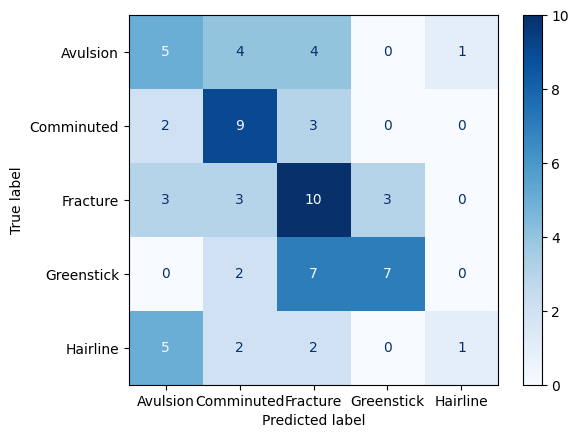

In [28]:
rf_predictions = rf_model.predict(test_bovw)

cm = confusion_matrix(y_test, rf_predictions)
plt.Figure(figsize=(10, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[name.split()[0] for name in class_list])
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Confusion Matrix Insights

Based on the confusion matrix:
1. The model performs well in classifying Greenstick fractures compared to other categories; however, it also misclassifies them at a similar rate as Fracture dislocations.
2. Fracture dislocation performs the best but at the same time, lots of other categories were misclassified as Fracture Dislocation
3. Hairline fracture performs the worst here, with only 1 sample test correctly classified, most of them were classified as Avulsion Fracture

# Error analysis

Let's examine the keypoints detected in an image that was correctly classified and compare them with those detected in an image that was misclassified.

In [311]:
sift = cv2.SIFT_create()
akaze = cv2.AKAZE_create()

# Index of correctly classified image as Fracture Dislocation (2)
correct_index = 38
correct_image = X_test[correct_index]
correct_bovw = test_bovw[correct_index]
correct_label = y_test[correct_index]
print(f"Prediction: {rf_model.predict([correct_bovw])}, Label: {correct_label}")

# Index of misclassified image of Greenstick Fracture (3) as Fracture Dislocation (2)
misclassified_index = 44
misclassified_label = y_test[misclassified_index]
misclassified_bovw = test_bovw[misclassified_index]
misclassified_image = X_test[misclassified_index]
print(f"Prediction: {rf_model.predict([misclassified_bovw])}, Label: {misclassified_label}")

Prediction: [2], Label: 2
Prediction: [3], Label: 2


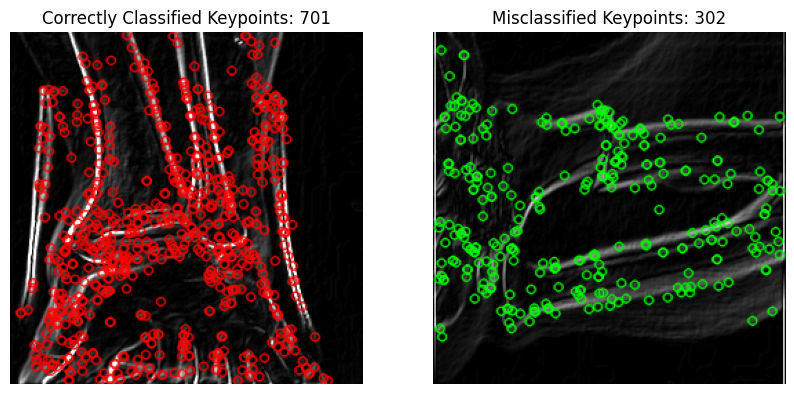

In [314]:
correct_kp_sift, correct_descriptors_sift = sift.detectAndCompute(correct_image, None)
misclassified_kp_sift, misclassified_descriptors_sift = sift.detectAndCompute(misclassified_image, None)

correct_kp_akaze, correct_descriptors_akaze = akaze.detectAndCompute(correct_image, None)
misclassified_kp_akaze, misclassified_descriptors_akaze = akaze.detectAndCompute(misclassified_image, None)

correct_display_sift = cv2.drawKeypoints(correct_image, correct_kp_sift + correct_kp_akaze, None, color=(255, 0, 0))
misclassified_display_sift = cv2.drawKeypoints(misclassified_image, misclassified_kp_sift + misclassified_kp_akaze, None, color=(0, 255, 0))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(correct_display_sift)
plt.title(f"Correctly Classified Keypoints: {len(correct_kp_sift + correct_kp_akaze)}")
plt.axis(False)

plt.subplot(1, 2, 2)
plt.imshow(misclassified_display_sift)
plt.title(f"Misclassified Keypoints: {len(misclassified_kp_sift + misclassified_kp_akaze)}")
plt.axis(False)

plt.show()

In [313]:
def preprocess(image):
    blurred_image = cv2.medianBlur(image, 5)

    sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)
    sobel_edges = sobel_x + sobel_y

    edge_detected_image = cv2.convertScaleAbs(sobel_edges)

    return np.array(edge_detected_image)

correct_image = preprocess(correct_image)
misclassified_image = preprocess(misclassified_image)